# Javier Blanco Cordero
Contact: javierblancordero@gmail.com
## causaLens - Code Test
27/06/2020

# 0. Helpers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import sys
import scipy.stats
import pickle
from pandas.plotting import register_matplotlib_converters

from sklearn import linear_model
from statsmodels.tsa._stl import STL
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from statsmodels.graphics import tsaplots
from fbprophet import Prophet
import ephem

In [2]:
# https://rhodesmill.org/pyephem/quick.html#bodies
    
def get_AU_distance_to_moon(date):
    """Returns AU distance to earth-moon given a date"""
    moon = ephem.Moon
    return moon(date).earth_distance
    
def get_AU_distance_to_sun(date):
    """Returns AU distance to earth-sun given a date"""
    sun = ephem.Sun
    return sun(date).earth_distance

In [3]:
def get_phase_on_day(date):
  """Returns a floating-point number from 0-1. where 0=new, 1=full"""
  
  date = ephem.Date(date)
  nnm = ephem.next_new_moon    (date)
  pnm = ephem.previous_new_moon(date)

  lunation=(date-pnm)/(nnm-pnm)

  return (math.sin(math.pi*lunation))

In [4]:
sns.set()
plt.rcParams['figure.figsize'] = (20, 5)
register_matplotlib_converters()

In [5]:
def month_diff(a, b):
    return 12 * (a.year - b.year) + (a.month - b.month)

def year_diff(a, b):
    return (a.year - b.year)

In [6]:
def plot_AC_and_PAC(series, lags):
    fig, (ax1,ax2) = plt.subplots(1, 2)
    
    tsaplots.plot_acf(series, ax=ax1, lags=lags, alpha=.05)
    ax1.set_title('AC '+series.name)
    
    tsaplots.plot_pacf(series, ax=ax2, lags=lags, alpha=.05)
    ax2.set_title('PAC ' +series.name)
    plt.show()

In [7]:
def plot_residuals_distribution(total_residuals, train_residuals, test_residuals, lags):
    plt.plot(train_residuals.index, train_residuals, color='blue', alpha=.75, label='train')
    plt.plot(test_residuals.index, test_residuals, color='red', alpha=.75, label='test')
    plt.title('Residuals evolution', size=15)
    plt.axvline(train_df.index[-1], color='grey', linewidth=4, alpha=.2)
    plt.axvline(test_df.index[-1], color='grey', linewidth=4, alpha=.2)
    plt.legend()
    plt.show()
    
    fig, (ax1,ax2) = plt.subplots(1, 2)
    tsaplots.plot_acf(train_residuals, ax=ax1, lags=lags, alpha=.05, label='train', color='blue')
    tsaplots.plot_acf(test_residuals, ax=ax1, lags=lags, alpha=.05, label='test', color='red')
    ax1.set_title('Residuals Autocorrelation')
    
    ax2.set_title('Residuals Distribution')
    sns.distplot(train_residuals, ax=ax2, label='train', color='blue')
    sns.distplot(test_residuals, ax=ax2, label='test', color='red')
    plt.axvline(0, color='black', linewidth=1)
    
    plt.legend()
    plt.show()

In [8]:
def progressBar(value, endvalue, bar_length=20):
    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length) - 1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write(
        "\rPercent: [{0}] {1}%".format(arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()

In [9]:
def prophet_predict_by_chunks(df_to_forecast, model):
    """ 
    Prophet seems to struggle with big chunks of data. 
    Let's break it into smaller pieces.
    """
    index_df = pd.DatetimeIndex(df_to_forecast['ds'])
    forecast = pd.DataFrame()
    total_chunks = 0
    for i, year in enumerate(list(index_df.year.unique())):
        for j, month in enumerate(list(index_df[index_df.year==year].month.unique())):
            total_chunks += 1
    
    iteration = 0
    for year in list(index_df.year.unique()):
        for month in list(index_df[index_df.year==year].month.unique()):
            df_ij = df_to_forecast.loc[((index_df.year == year)&(index_df.month == month))]
            forecast = forecast.append(model.predict(df_ij))
            
            iteration += 1
            progressBar(iteration, total_chunks, bar_length=20)
    
    return forecast

# 1. Import data
### 1.1 Load data

In [10]:
main_df = pd.read_csv('Data/venezia_transformed.csv')

display(main_df.head())
main_df.info()

,datetime,level,moon_dist,sun_dist,moon_phase,sun_acceleration,Venice_relative_subsidence,CSIRO_adj_sea_level,adj_level
0,1983-01-01 01:00:00,44.0,0.002394,0.983272,0.983233,6.125102e-23,0.000000,1.12,42.880000
1,1983-01-01 02:00:00,35.0,0.002395,0.983271,0.982423,6.125107e-23,0.000011,1.12,33.879989
2,1983-01-01 03:00:00,23.0,0.002396,0.983271,0.981594,6.125112e-23,0.000023,1.12,21.879977
3,1983-01-01 04:00:00,10.0,0.002396,0.983271,0.980747,6.125117e-23,0.000034,1.12,8.879966
4,1983-01-01 05:00:00,1.0,0.002397,0.983270,0.979880,6.125122e-23,0.000046,1.12,-0.120046


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289280 entries, 0 to 289279
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   datetime                    289280 non-null  object 
 1   level                       289280 non-null  float64
 2   moon_dist                   289280 non-null  float64
 3   sun_dist                    289280 non-null  float64
 4   moon_phase                  289280 non-null  float64
 5   sun_acceleration            289280 non-null  float64
 6   Venice_relative_subsidence  289280 non-null  float64
 7   CSIRO_adj_sea_level         289280 non-null  float64
 8   adj_level                   289280 non-null  float64
dtypes: float64(8), object(1)
memory usage: 19.9+ MB


In [11]:
date_column = 'datetime'
forecast_column = 'level'

features = sorted(set(main_df.columns) - set([date_column, forecast_column]))

### 2.1 First data checks

In [12]:
# Convert date column into datetime format
main_df[date_column] = pd.to_datetime(main_df[date_column], format='%Y-%m-%d %H', errors='coerce') #'%m/%d/%Y'

# Also, create a DateTimeIndex
main_df.index = pd.DatetimeIndex(main_df[date_column])
main_df.index.name = None

# Use to_numeric in case there´s presence of strings
for column in [forecast_column] + features:
    main_df[column] = pd.to_numeric(main_df[column], errors='coerce')

# Sort data out chronologically
main_df.sort_index(inplace=True)
display(main_df.head())
display(main_df.tail())

,datetime,level,moon_dist,sun_dist,moon_phase,sun_acceleration,Venice_relative_subsidence,CSIRO_adj_sea_level,adj_level
1983-01-01 01:00:00,1983-01-01 01:00:00,44.0,0.002394,0.983272,0.983233,6.125102e-23,0.000000,1.12,42.880000
1983-01-01 02:00:00,1983-01-01 02:00:00,35.0,0.002395,0.983271,0.982423,6.125107e-23,0.000011,1.12,33.879989
1983-01-01 03:00:00,1983-01-01 03:00:00,23.0,0.002396,0.983271,0.981594,6.125112e-23,0.000023,1.12,21.879977
1983-01-01 04:00:00,1983-01-01 04:00:00,10.0,0.002396,0.983271,0.980747,6.125117e-23,0.000034,1.12,8.879966
1983-01-01 05:00:00,1983-01-01 05:00:00,1.0,0.002397,0.983270,0.979880,6.125122e-23,0.000046,1.12,-0.120046


,datetime,level,moon_dist,sun_dist,moon_phase,sun_acceleration,Venice_relative_subsidence,CSIRO_adj_sea_level,adj_level
2015-12-31 20:00:00,2015-12-31 20:00:00,-18.0,0.002690,0.983315,0.829786,6.124559e-23,3.302203,13.218625,-34.520828
2015-12-31 21:00:00,2015-12-31 21:00:00,-14.0,0.002691,0.983315,0.827312,6.124565e-23,3.302215,13.218748,-30.520962
2015-12-31 22:00:00,2015-12-31 22:00:00,-5.0,0.002692,0.983315,0.824822,6.124570e-23,3.302226,13.218871,-21.521097
2015-12-31 23:00:00,2015-12-31 23:00:00,8.0,0.002692,0.983314,0.822316,6.124575e-23,3.302237,13.218994,-8.521231
2016-01-01 00:00:00,2016-01-01 00:00:00,20.0,0.002693,0.983314,0.819793,6.124581e-23,3.302249,13.219117,3.478634


In [13]:
# Frequency seems hourly. Let´s double check
print('dataframe rows: ' + str(len(main_df.index.unique())))

print('hours elapsed: ' + str((main_df.index.max() - main_df.index.min())/pd.Timedelta(hours=1) + 1))

dataframe rows: 289272
hours elapsed: 289272.0


# 2. Modelling exploratory

## 2.0 Train-test split

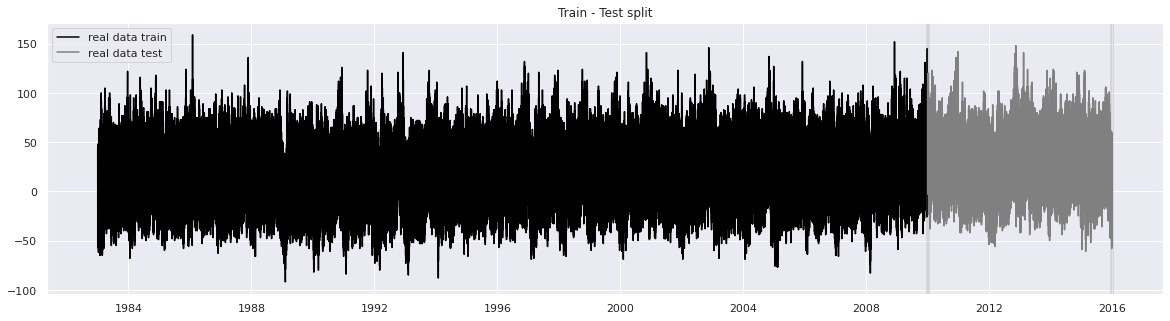

In [14]:
separating_date_1 = pd.to_datetime('20100101', format='%Y%m%d')
separating_date_2 = pd.to_datetime('20201201', format='%Y%m%d')
train_df = main_df.loc[main_df.index < separating_date_1]
test_df = main_df.loc[((main_df.index >= separating_date_1)&(main_df.index < separating_date_2))]


# Visualise train test split
plt.title('Train - Test split')
plt.plot(train_df.index, train_df[forecast_column], color='black', label='real data train')
plt.plot(test_df.index, test_df[forecast_column], color='grey', label='real data test')
plt.axvline(separating_date_1, color='grey', linewidth=4, alpha=.2)
plt.axvline(test_df.index[-1], color='grey', linewidth=4, alpha=.2)
plt.legend()
plt.show()

# 2.1 STL Decomposition

In [ ]:
# https://www.statsmodels.org/devel/examples/notebooks/generated/stl_decomposition.html
plt.rcParams['figure.figsize'] = 20,20
res = STL(train_df[forecast_column], period=24*29).fit()
fig = res.plot()
plt.show()
plt.rcParams['figure.figsize'] = (20, 5)

In [ ]:
# Strenth of components
# Reference: https://otexts.com/fpp2/seasonal-strength.html
Tt = getattr(res, 'trend') # smoothed trend component
St = getattr(res, 'seasonal') # seasonal component
Rt = getattr(res, 'resid') # remainder component

# Strenth of trend (0 - 1 | small - big trend)
Ft = max(0, 1-(np.var(Rt)/np.var(Tt+Rt)))
print("Strenth of trend: " +str(round(Ft,2)))

# Strenth of seasonality (0 - 1 | small - big seasonality)
Fs = max(0, 1-(np.var(Rt)/np.var(St+Rt)))
print("Strenth of seasonality: " +str(round(Fs,2)))

# 2.2 Differenciation

In [ ]:
lags = 25

In [ ]:
# https://otexts.com/fpp2/stationarity.html

# First order differencing
main_df['diff('+forecast_column+')'] = main_df[forecast_column] - main_df[forecast_column].shift(1)

# Second order differencing
main_df['diff(diff('+forecast_column+'))'] = main_df['diff('+forecast_column+')'] - (main_df[forecast_column].shift(1) - main_df[forecast_column].shift(2))


# Plotting
plot_AC_and_PAC(main_df[forecast_column], lags) # Original
plot_AC_and_PAC(main_df['diff('+forecast_column+')'].dropna(), lags) # First differencing
plot_AC_and_PAC(main_df['diff(diff('+forecast_column+'))'].dropna(), lags) # Second order differencing

In [ ]:
# https://otexts.com/fpp2/stationarity.html

# Seasonal differencing
main_df['lag-12 diff('+forecast_column+')'] = main_df[forecast_column] - main_df[forecast_column].shift(24)

# Second order seasonal differencing
main_df['diff(lag-12 diff('+forecast_column+'))'] = main_df['lag-12 diff('+forecast_column+')'] - (main_df[forecast_column].shift(1)-main_df[forecast_column].shift(25))

# Plotting
plot_AC_and_PAC(main_df[forecast_column], lags) # Original
plot_AC_and_PAC(main_df['lag-12 diff('+forecast_column+')'].dropna(), lags) # Seasonal differencing
plot_AC_and_PAC(main_df['diff(lag-12 diff('+forecast_column+'))'].dropna(), lags) # Seasonal differencing with further differencing

# 2.3 Prophet - simple with daily seasonality

In [20]:
train_prophet = train_df[forecast_column].reset_index()
train_prophet.columns = ['ds','y']
test_prophet = test_df[forecast_column].reset_index()
test_prophet.columns = ['ds','y']

# Prophet https://facebook.github.io/prophet/docs/
m_1 = Prophet(seasonality_mode='multiplicative', 
              interval_width=0.95, 
              daily_seasonality = True, 
              weekly_seasonality = False, 
              yearly_seasonality = False)

m_1.fit(train_prophet)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [25]:
# Predict over train data
"""
forecast_train = prophet_predict_by_chunks(train_prophet, m_1)
forecast_train.to_csv('Data/Venezia/m1_forecast_train.csv')
"""
forecast_train = pd.read_csv('Data/Venezia/m1_forecast_train.csv').drop('Unnamed: 0', axis=1)
forecast_train['ds'] = pd.to_datetime(forecast_train['ds'], errors='coerce')
forecast_train.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1983-01-01 01:00:00,18.802156,-33.191983,71.362434,18.802156,18.802156,0.203790,0.203790,0.203790,0.203790,0.203790,0.203790,0.0,0.0,0.0,22.633843
1,1983-01-01 02:00:00,18.802581,-37.714455,73.681704,18.802581,18.802581,-0.105233,-0.105233,-0.105233,-0.105233,-0.105233,-0.105233,0.0,0.0,0.0,16.823928
2,1983-01-01 03:00:00,18.803005,-40.637366,65.522994,18.803005,18.803005,-0.397640,-0.397640,-0.397640,-0.397640,-0.397640,-0.397640,0.0,0.0,0.0,11.326169
3,1983-01-01 04:00:00,18.803430,-44.998475,58.637280,18.803430,18.803430,-0.595334,-0.595334,-0.595334,-0.595334,-0.595334,-0.595334,0.0,0.0,0.0,7.609111
4,1983-01-01 05:00:00,18.803855,-45.432375,57.486226,18.803855,18.803855,-0.642595,-0.642595,-0.642595,-0.642595,-0.642595,-0.642595,0.0,0.0,0.0,6.720584


In [24]:
# Predict over validation data 
"""
forecast_test = prophet_predict_by_chunks(test_prophet, m_1)
forecast_test.to_csv('Data/Venezia/m1_forecast_test.csv')
"""
forecast_test = pd.read_csv('Data/Venezia/m1_forecast_test.csv').drop('Unnamed: 0', axis=1)
forecast_test['ds'] = pd.to_datetime(forecast_test['ds'], errors='coerce')
forecast_test.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2010-01-01 00:00:00,30.276362,-10.578822,93.414324,30.276362,30.276362,0.451627,0.451627,0.451627,0.451627,0.451627,0.451627,0.0,0.0,0.0,43.949991
1,2010-01-01 01:00:00,30.276475,-18.614100,88.452189,30.276475,30.276475,0.203790,0.203790,0.203790,0.203790,0.203790,0.203790,0.0,0.0,0.0,36.446511
2,2010-01-01 02:00:00,30.276589,-22.795175,79.664557,30.276589,30.276589,-0.105233,-0.105233,-0.105233,-0.105233,-0.105233,-0.105233,0.0,0.0,0.0,27.090492
3,2010-01-01 03:00:00,30.276702,-35.023933,72.583007,30.276702,30.276702,-0.397640,-0.397640,-0.397640,-0.397640,-0.397640,-0.397640,0.0,0.0,0.0,18.237459
4,2010-01-01 04:00:00,30.276816,-39.291214,66.254213,30.276816,30.276816,-0.595334,-0.595334,-0.595334,-0.595334,-0.595334,-0.595334,0.0,0.0,0.0,12.252001


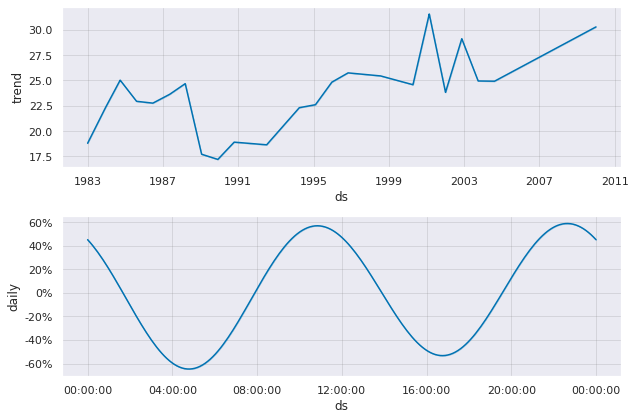

In [84]:
# Plot Prophet components
fig = m_1.plot_components(forecast_train)
plt.show()

In [17]:
y_train_pred = forecast_train[['ds','yhat']].set_index('ds',drop=True)
y_train_pred.index.name = None
y_train_pred = y_train_pred['yhat']

y_test_pred = forecast_test[['ds','yhat']].set_index('ds',drop=True)
y_test_pred.index.name = None
y_test_pred = y_test_pred['yhat']

y_all_pred = y_train_pred.append(y_test_pred)

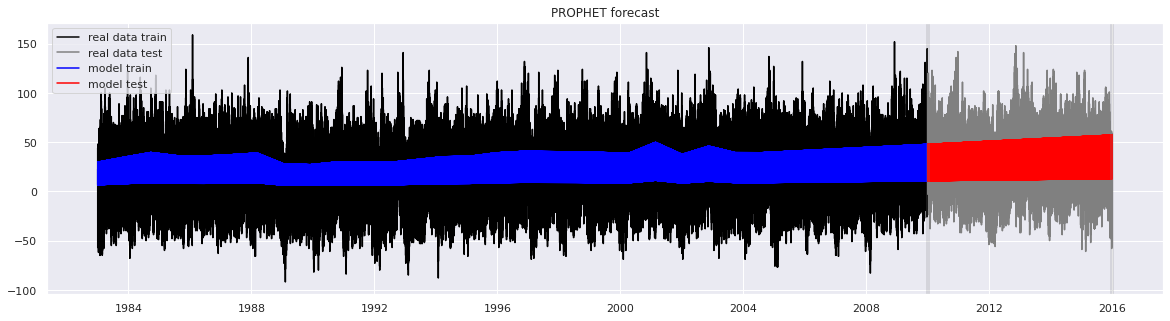

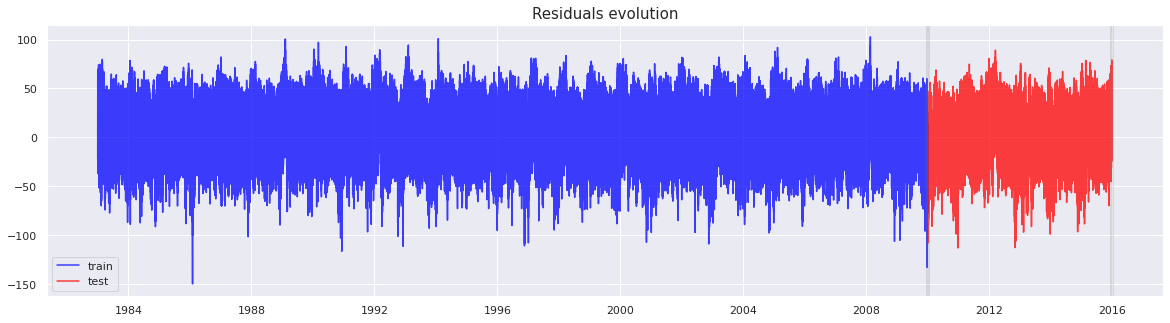

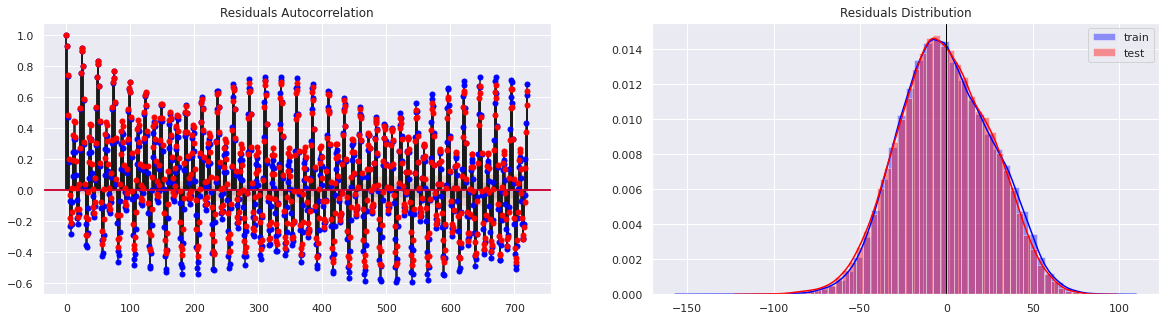

In [18]:
# PLOT

# Visualise forecast
plt.title('PROPHET forecast')
# Real data
plt.plot(train_df.index, train_df[forecast_column], color='black', label='real data train')
plt.plot(test_df.index, test_df[forecast_column], color='grey', label='real data test')
# Model
plt.plot(y_train_pred.index, y_train_pred, color='blue', label='model train')
plt.plot(y_test_pred.index, y_test_pred, color='red', label='model test')
# Test reference lines
plt.axvline(separating_date_1, color='grey', linewidth=4, alpha=.2)
plt.axvline(test_df.index[-1], color='grey', linewidth=4, alpha=.2)
plt.legend()
plt.show()


# Plot residuals
residuals_train = y_train_pred - train_df[forecast_column]
errors_test = y_test_pred - test_df[forecast_column]
residuales_totales = y_all_pred - main_df[forecast_column]
plot_residuals_distribution(residuales_totales, residuals_train, errors_test, 24*30)

In [27]:
y_test_pred

2010-01-01 00:00:00    43.949991
2010-01-01 01:00:00    36.446511
2010-01-01 02:00:00    27.090492
2010-01-01 03:00:00    18.237459
2010-01-01 04:00:00    12.252001
                         ...    
2015-12-31 20:00:00    40.797806
2015-12-31 21:00:00    50.430674
2015-12-31 22:00:00    56.419570
2015-12-31 23:00:00    57.221802
2016-01-01 00:00:00    52.603239
Name: yhat, Length: 52587, dtype: float64

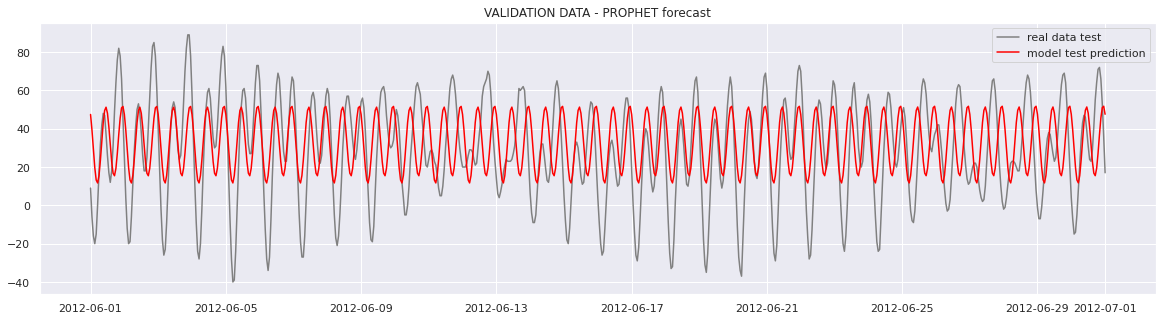

In [28]:
# Zoom in
date_i = pd.to_datetime('2012-06-01', format='%Y-%m-%d %H')
date_j = pd.to_datetime('2012-07-01', format='%Y-%m-%d %H')

plt.title('VALIDATION DATA - PROPHET forecast')
# Real data
plt.plot(test_df.index[((test_df['datetime']>=date_i)&(test_df['datetime']<=date_j))], test_df[forecast_column][((test_df['datetime']>=date_i)&(test_df['datetime']<=date_j))], color='grey', label='real data test')
# Model
plt.plot(y_test_pred.index[((y_test_pred.index>=date_i)&(y_test_pred.index<=date_j))], y_test_pred[((y_test_pred.index>=date_i)&(y_test_pred.index<=date_j))], color='red', label='model test prediction')
plt.legend()
plt.show()

In [88]:
evaluation = pd.DataFrame({'Metrics': ['MAPE', 'MSE', 'R2'],
                           'Train': [np.median(np.abs((train_df[forecast_column] - y_train_pred) / train_df[forecast_column])), 
                                     np.sqrt(((y_train_pred - train_df[forecast_column]) ** 2).mean()), 
                                     r2_score(train_df[forecast_column], y_train_pred)], 
                           'Test': [np.median(np.abs((test_df[forecast_column] - y_test_pred) / test_df[forecast_column])), 
                                     np.sqrt(((y_test_pred - test_df[forecast_column]) ** 2).mean()), 
                                     r2_score(test_df[forecast_column], y_test_pred)]
                          })

evaluation['Degradation (%)'] = round(100*(evaluation['Test']-evaluation['Train'])/evaluation['Train'],2)
evaluation

,Metrics,Train,Test,Degradation (%)
0,MAPE,0.586272,0.485373,-17.21
1,MSE,26.885344,26.773308,-0.42
2,R2,0.142084,0.090210,-36.51
